<a href="https://colab.research.google.com/github/shravs45/Machine-Learning/blob/Finance-Industry/Identify_unengaged_users.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle     
import seaborn as sns
from scipy.stats import skew
import time

from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
BASE_PATH='/content/drive/MyDrive/Final Project2/'

In [3]:
def save_pickle_files(filename,data):
  with open(BASE_PATH+filename,'wb') as f:
    pickle.dump(data,f)

In [4]:
def load_pickle_files(filename):
  data=''
  #load python objects using pickle
  with open(BASE_PATH+filename,'rb') as f:
    data = pickle.load(f)
  return data

In [5]:
marketing_data=pd.read_csv('/content/drive/MyDrive/Final Project2/marketing_monthly_data.csv')
monthly_data=pd.read_csv('/content/drive/MyDrive/Final Project2/transaction_monthly_data.csv')
trans_details=pd.read_csv('/content/drive/MyDrive/Final Project2/transaction_details_data.csv')

In [6]:
working_marketing_data=marketing_data.copy()
working_monthly_data=monthly_data.copy()
working_trans_details=trans_details.copy()

In [7]:
#To release RAM
del marketing_data
del monthly_data
del trans_details

# **TASK 2**

# **Part A:**

1. **Convert the user_created_date and created_date columns from
marketing_monthly_data & transaction_details_data datasets into usable datetime
formats**

In [ ]:
working_marketing_data['c_date']=pd.to_datetime(working_marketing_data['user_created_date']).dt.date
# Extract date part from created_date
working_trans_details['c_date']=pd.to_datetime(working_trans_details['created_date']).dt.date
# Extract Year from c_date in transdetails
working_trans_details['Year']=pd.to_datetime(working_trans_details['c_date']).dt.year
# Extract days of year from date
working_trans_details['days']=pd.to_datetime(working_trans_details['created_date']).dt.dayofyear

2. Create a new data frame that satisfies the below criteria:<br>
o **Contains 1 record per customer<br>
o Only COMPLETED transactions are considered<br>
o Captures average 3-months behavior across the tenure of each customer along four engagement-specific dimensions, as stated below:**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1) Number of transactions (Use count of amount_usd)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) Total USD value of transactions (Use sum of amount_usd)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3) Total distinct types of transactions (Use transactions_type)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4) Total distinct days of transactions (Use created_date)

In [ ]:
# Extract Year and Month part from c_date
working_trans_details['yearmonth'] = working_trans_details['c_date'].astype(str).str.replace('-','').str.slice(0,6).astype('int64')
# Consider only Completed Transactions
txns_completed_data = working_trans_details[(working_trans_details['transactions_state']=='COMPLETED')]
# group by user across yearmonth
txns_completed_data = txns_completed_data.groupby(['user_id','yearmonth']).agg({'amount_usd':['count','sum'],
                                                            'transactions_type':pd.Series.nunique,
                                                          'created_date':pd.Series.nunique}).reset_index()
txns_completed_data.columns=['user_id','yearmonth','No_of_trans','Total_USD_amount','Total_distinct_trans_type','Total_trans_days']
# get only 2018 records
txn_details_2018=txns_completed_data[txns_completed_data['yearmonth'].astype(str).str.slice(0,4)=='2018']
# get 2019 records also
txn_details_2019=txns_completed_data[txns_completed_data['yearmonth'].astype(str).str.slice(0,4)=='2019']
#get last 3 months records for each user in 2018
last3months = txn_details_2018.groupby(['user_id']).tail(3)
last3months_2019 = txn_details_2019.groupby(['user_id']).tail(3)

#take average of last 3 months for each dimension
avg_3_months_txns = last3months.groupby('user_id').agg({'No_of_trans':'mean',
                                    'Total_USD_amount':'mean',
                                    'Total_distinct_trans_type':'mean',
                                    'Total_trans_days':'mean'}).reset_index()

avg_3_months_txns_2019 = last3months_2019.groupby('user_id').agg({'No_of_trans':'mean',
                                    'Total_USD_amount':'mean',
                                    'Total_distinct_trans_type':'mean',
                                    'Total_trans_days':'mean'}).reset_index()

# rounding off the mean values for 2018
avg_3_months_txns['No_of_trans'] = avg_3_months_txns['No_of_trans'].astype('int64')
avg_3_months_txns['Total_distinct_trans_type'] = avg_3_months_txns['Total_distinct_trans_type'].astype('int64')
avg_3_months_txns['Total_trans_days'] = avg_3_months_txns['Total_trans_days'].astype('int64')
avg_3_months_txns['Total_USD_amount'] = avg_3_months_txns['Total_USD_amount'].round(2)


# rounding off the mean values for 2019
avg_3_months_txns_2019['No_of_trans'] = avg_3_months_txns_2019['No_of_trans'].astype('int64')
avg_3_months_txns_2019['Total_distinct_trans_type'] = avg_3_months_txns_2019['Total_distinct_trans_type'].astype('int64')
avg_3_months_txns_2019['Total_trans_days'] = avg_3_months_txns_2019['Total_trans_days'].astype('int64')
avg_3_months_txns_2019['Total_USD_amount'] = avg_3_months_txns_2019['Total_USD_amount'].round(2)

In [ ]:
# save Files for future
save_pickle_files('completed_txn_details.pickle',txns_completed_data)
save_pickle_files('avg_3_months_txns_2018.pickle',avg_3_months_txns)
save_pickle_files('avg_3_months_txns_2019.pickle',avg_3_months_txns_2019)

# **Part B - [Unsupervised Learning]**

In [ ]:
# load the 3months avg for each user data
avg_3_months_txns=load_pickle_files('avg_3_months_txns_2018.pickle')
avg_3_months_txns_2019=load_pickle_files('avg_3_months_txns_2019.pickle')

In [ ]:
avg_3_months_txns.describe()

,No_of_trans,Total_USD_amount,Total_distinct_trans_type,Total_trans_days
count,17580.000000,17580.000000,17580.000000,17580.000000
mean,14.367975,992.616016,2.246530,14.365245
std,24.433862,8568.913833,1.093593,24.429258
min,1.000000,0.010000,1.000000,1.000000
25%,2.000000,33.330000,1.000000,2.000000
50%,6.000000,238.485000,2.000000,6.000000
75%,16.000000,801.072500,3.000000,16.000000
max,609.000000,708032.180000,8.000000,609.000000


In [ ]:
avg_3_months_txns_2019.describe()

,No_of_trans,Total_USD_amount,Total_distinct_trans_type,Total_trans_days
count,14694.000000,14694.000000,14694.000000,14694.000000
mean,17.730298,1153.443315,2.336804,17.727984
std,27.206133,5384.977192,1.110580,27.201650
min,1.000000,0.000000,1.000000,1.000000
25%,3.000000,93.670000,1.000000,3.000000
50%,8.000000,348.065000,2.000000,8.000000
75%,21.000000,960.595000,3.000000,21.000000
max,545.000000,267576.620000,7.000000,545.000000


# Checking Outliers

In [ ]:
avg_3_months_txns.drop('user_id',inplace=True,axis=1)
avg_3_months_txns_2019.drop('user_id',inplace=True,axis=1)

Skew in column  No_of_trans 5.142226850534351
Skew in column  Total_USD_amount 63.83189606459644
Skew in column  Total_distinct_trans_type 0.8666946893105743
Skew in column  Total_trans_days 5.141453518988516


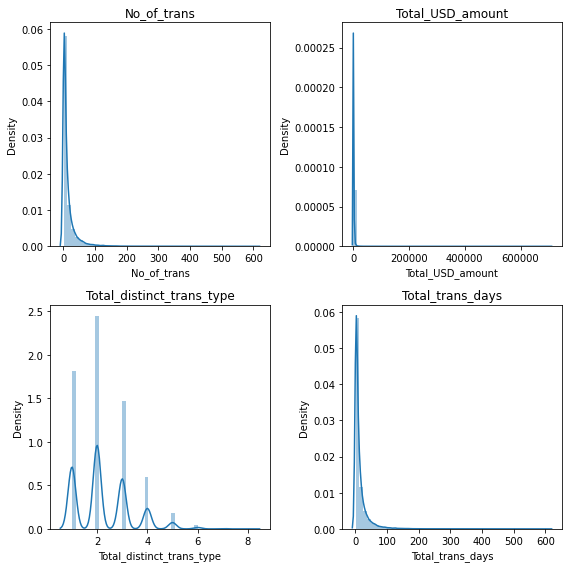

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(8,8))
for i,col in enumerate(avg_3_months_txns):
  print('Skew in column ',col,skew(avg_3_months_txns[col]))
  sns.distplot(avg_3_months_txns[col],ax=axes.flatten()[i])
  axes.flatten()[i].set_title(col)
fig.tight_layout()
plt.show()

All the columns are heavily skewed.

{'boxes': [<matplotlib.lines.Line2D at 0x7f31c9744790>],
 'caps': [<matplotlib.lines.Line2D at 0x7f31c974c790>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f31c97537d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f31c9753290>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f31c9744cd0>,
  <matplotlib.lines.Line2D at 0x7f31c974c250>]}

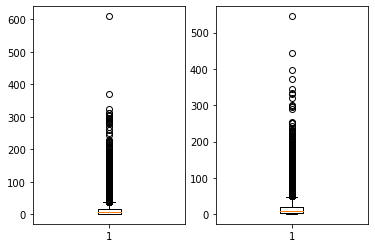

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.boxplot(avg_3_months_txns['No_of_trans'])
ax2.boxplot(avg_3_months_txns_2019['No_of_trans'])
#avg_3_months_txns.boxplot(column='No_of_trans',grid=False)

{'boxes': [<matplotlib.lines.Line2D at 0x7f31c969dfd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f31c96ae050>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f31c96b7090>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f31c96aeb10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f31c96a7590>,
  <matplotlib.lines.Line2D at 0x7f31c96a7ad0>]}

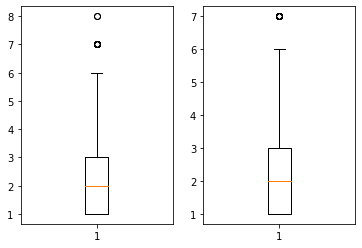

In [ ]:
#avg_3_months_txns.boxplot(column='Total_distinct_trans_type',grid=False)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.boxplot(avg_3_months_txns['Total_distinct_trans_type'])
ax2.boxplot(avg_3_months_txns_2019['Total_distinct_trans_type'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f31c94c1c50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f31c94cac90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f31c94d3cd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f31c94d3790>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f31c94ca210>,
  <matplotlib.lines.Line2D at 0x7f31c94ca750>]}

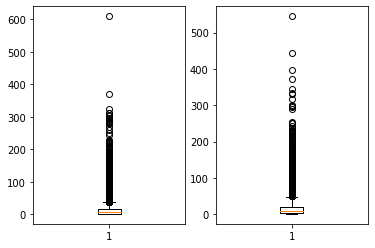

In [ ]:
#avg_3_months_txns.boxplot(column='Total_trans_days',grid=False)
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.boxplot(avg_3_months_txns['Total_trans_days'])
ax2.boxplot(avg_3_months_txns_2019['Total_trans_days'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f31c941db10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f31c9426b50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f31c942eb90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f31c942e650>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f31c94260d0>,
  <matplotlib.lines.Line2D at 0x7f31c9426610>]}

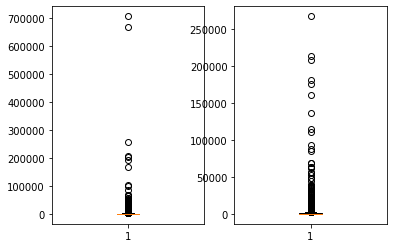

In [ ]:
#avg_3_months_txns.boxplot(column='Total_USD_amount',grid=False)
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.boxplot(avg_3_months_txns['Total_USD_amount'])
ax2.boxplot(avg_3_months_txns_2019['Total_USD_amount'])

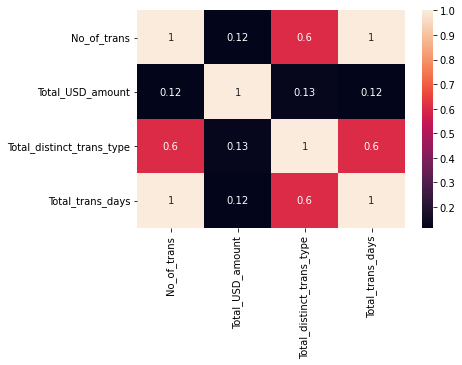

In [ ]:
sns.heatmap(avg_3_months_txns.corr(),annot=True)
plt.show()

# Handling Outliers

In [ ]:
q1_amt,q3_amt=np.percentile(avg_3_months_txns['Total_USD_amount'],[25,75])
q1_cnt,q3_cnt=np.percentile(avg_3_months_txns['No_of_trans'],[25,75])
q1_type,q3_type=np.percentile(avg_3_months_txns['Total_distinct_trans_type'],[25,75])

q1_amt_2019,q3_amt_2019=np.percentile(avg_3_months_txns_2019['Total_USD_amount'],[25,75])
q1_cnt_2019,q3_cnt_2019=np.percentile(avg_3_months_txns_2019['No_of_trans'],[25,75])
q1_type_2019,q3_type_2019=np.percentile(avg_3_months_txns_2019['Total_distinct_trans_type'],[25,75])

In [ ]:
lb_amt=q1_amt*1.5
ub_amt=q3_amt*1.5
lb_cnt=q1_cnt*1.5
ub_cnt=q3_cnt*1.5
lb_type=q1_type*1.5
ub_type=q3_type*1.5

In [ ]:
lb_amt_2019=q1_amt_2019*1.5
ub_amt_2019=q3_amt_2019*1.5
lb_cnt_2019=q1_cnt_2019*1.5
ub_cnt_2019=q3_cnt_2019*1.5
lb_type_2019=q1_type_2019*1.5
ub_type_2019=q3_type_2019*1.5

As txn_days and No_of_txn are quite similar, To avoid redundancy dropping txn_days

In [ ]:
avg_3_months_txns.drop(['Total_trans_days'],axis=1,inplace=True)
avg_3_months_txns_2019.drop(['Total_trans_days'],axis=1,inplace=True)

In [ ]:
outliers_removed_data=avg_3_months_txns[(avg_3_months_txns['Total_USD_amount']>=lb_amt) & (avg_3_months_txns['Total_USD_amount']<=ub_amt) & 
                                                   (avg_3_months_txns['No_of_trans']>=lb_cnt) & (avg_3_months_txns['No_of_trans']<=ub_cnt) & 
                                                   (avg_3_months_txns['Total_distinct_trans_type']>=lb_type) & (avg_3_months_txns['Total_distinct_trans_type']<=ub_type)]

In [ ]:
outliers_removed_data_2019=avg_3_months_txns_2019[(avg_3_months_txns_2019['Total_USD_amount']>=lb_amt_2019) & (avg_3_months_txns_2019['Total_USD_amount']<=ub_amt_2019) & 
                                                   (avg_3_months_txns_2019['No_of_trans']>=lb_cnt_2019) & (avg_3_months_txns_2019['No_of_trans']<=ub_cnt_2019) & 
                                                   (avg_3_months_txns_2019['Total_distinct_trans_type']>=lb_type_2019) & (avg_3_months_txns_2019['Total_distinct_trans_type']<=ub_type_2019)]

[Text(0.5, 0, 'txn_count')]

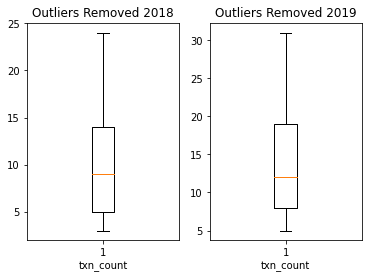

In [ ]:
#outliers_removed_data.boxplot(column='No_of_trans',grid=False)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.boxplot(outliers_removed_data['No_of_trans'])
ax2.boxplot(outliers_removed_data_2019['No_of_trans'])
ax1.set_title('Outliers Removed 2018')
ax2.set_title('Outliers Removed 2019')
ax1.set(xlabel='txn_count')
ax2.set(xlabel='txn_count')

[Text(0.5, 0, 'Distinct Txn Type')]

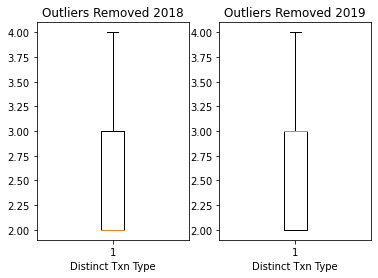

In [ ]:
#outliers_removed_data.boxplot(column='Total_distinct_trans_type',grid=False)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.boxplot(outliers_removed_data['Total_distinct_trans_type'])
ax2.boxplot(outliers_removed_data_2019['Total_distinct_trans_type'])
ax1.set_title('Outliers Removed 2018')
ax2.set_title('Outliers Removed 2019')
ax1.set(xlabel='Distinct Txn Type')
ax2.set(xlabel='Distinct Txn Type')

[Text(0.5, 0, 'Total_USD_amount')]

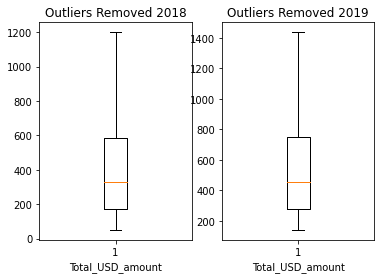

In [ ]:
#outliers_removed_data.boxplot(column='Total_USD_amount',grid=False)
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.boxplot(outliers_removed_data['Total_USD_amount'])
ax2.boxplot(outliers_removed_data_2019['Total_USD_amount'])
ax1.set_title('Outliers Removed 2018')
ax2.set_title('Outliers Removed 2019')
ax1.set(xlabel='Total_USD_amount')
ax2.set(xlabel='Total_USD_amount')

In [ ]:
print(outliers_removed_data.shape)
print(outliers_removed_data_2019.shape)

(6225, 4)
(4736, 3)


In [ ]:
save_pickle_files('Task2_Cleaned_data_2018.pickle',outliers_removed_data)
save_pickle_files('Task2_Cleaned_data_2019.pickle',outliers_removed_data_2019)

In [ ]:
# load the 3months avg for each user data
firstbatch_clean_data=load_pickle_files('Task2_Cleaned_data_2018.pickle')
firstbatch_clean_data_2019=load_pickle_files('Task2_Cleaned_data_2019.pickle')

In [ ]:
firstbatch_clean_data.describe()

,No_of_trans,Total_USD_amount,Total_distinct_trans_type
count,6225.000000,6225.000000,6225.000000
mean,9.866345,407.077422,2.477269
std,5.613041,289.915082,0.625229
min,3.000000,50.000000,2.000000
25%,5.000000,170.850000,2.000000
50%,9.000000,329.600000,2.000000
75%,14.000000,586.000000,3.000000
max,24.000000,1199.930000,4.000000


Skew in column  No_of_trans 0.7453951720106937
Skew in column  Total_USD_amount 0.8770301507918306
Skew in column  Total_distinct_trans_type 0.9536724000702536


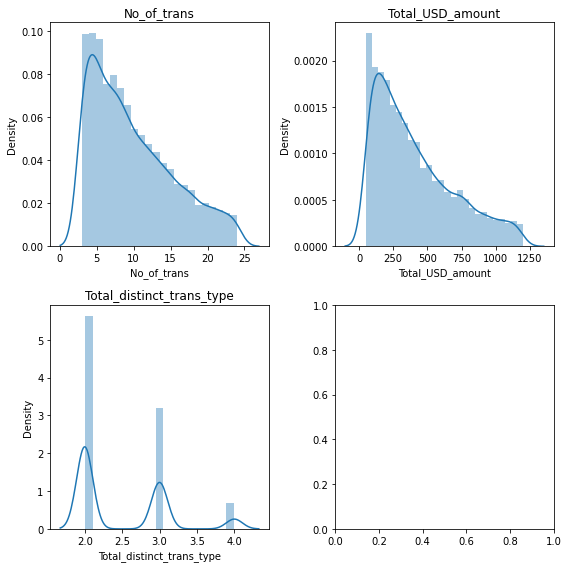

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(8,8))
for i,col in enumerate(firstbatch_clean_data):
  print('Skew in column ',col,skew(firstbatch_clean_data[col]))
  sns.distplot(firstbatch_clean_data[col],ax=axes.flatten()[i])
  axes.flatten()[i].set_title(col)
fig.tight_layout()
plt.show()

# **1. Use two popular clustering algorithms, K-means & Hierarchical**

# **i). K-means Clustering**

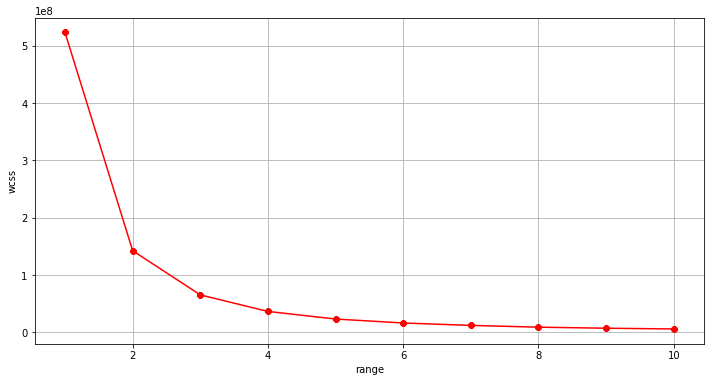

In [ ]:
wcss=[]

for k in range(1,11):
  kmeans=KMeans(n_clusters=k,init='k-means++')
  kmeans.fit(firstbatch_clean_data)
  wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss,color='red',marker='8')
plt.xlabel('range')
plt.ylabel('wcss')
plt.show()


In [ ]:
kmeans=KMeans(n_clusters=3)
s = time.time()
kmeans.fit(firstbatch_clean_data)
Kmeans_pred=kmeans.predict(firstbatch_clean_data)
e=time.time()
print("Time Taken by K-Means = {}".format(e - s))

Time Taken by K-Means = 0.2372145652770996


In [ ]:
kmeans_centroids=pd.DataFrame(kmeans.cluster_centers_)
kmeans_centroids.columns=['Cluster 0','Cluster 1','Cluster 2']
kmeans_centroids=kmeans_centroids.sort_values(by=['Cluster 0']).reset_index()
kmeans_centroids.drop('index',inplace=True,axis=1)
kmeans_centroids

,Cluster 0,Cluster 1,Cluster 2
0,7.978107,176.776819,2.366388
1,11.195344,481.703254,2.542004
2,12.699913,903.886719,2.666667


**Cluster  based on txn_amt_USD vs txn_count**

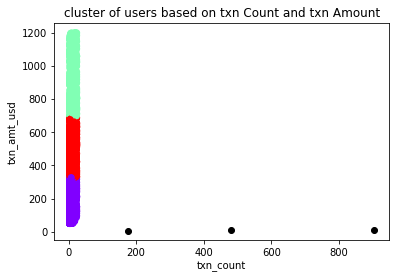

In [ ]:
plt.scatter(firstbatch_clean_data['No_of_trans'],firstbatch_clean_data['Total_USD_amount'],c=kmeans.labels_,cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0],color='black')
plt.title('cluster of users based on txn Count and txn Amount')
plt.xlabel('txn_count')
plt.ylabel('txn_amt_usd')
plt.show()

From the above Cluster, black color dot denotes ***Centroid*** for each cluster

In Cluster = 0, Users txn_amt_USD is between 1 to 350 & txn_count is between 1 to 40 <br>
In Cluster = 1, Users txn_amt_USD is between 350 to 750 & txn_count is between 1 to 40 <br>
In Cluster = 2, users txn_amt_USD is between 750 to 1200 & txn_count is between 1 to 40 

**Cluster based on txn_amt_USD vs txn_type**

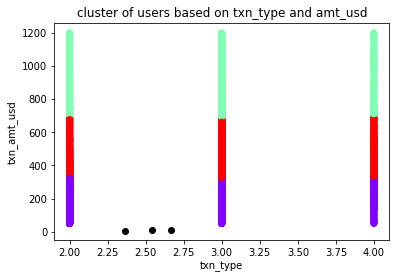

In [ ]:
plt.scatter(firstbatch_clean_data['Total_distinct_trans_type'],firstbatch_clean_data['Total_USD_amount'],c=kmeans.labels_,cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,2],kmeans.cluster_centers_[:,0],color='black')
plt.title('cluster of users based on txn_type and amt_usd')
plt.xlabel('txn_type')
plt.ylabel('txn_amt_usd')
plt.show()

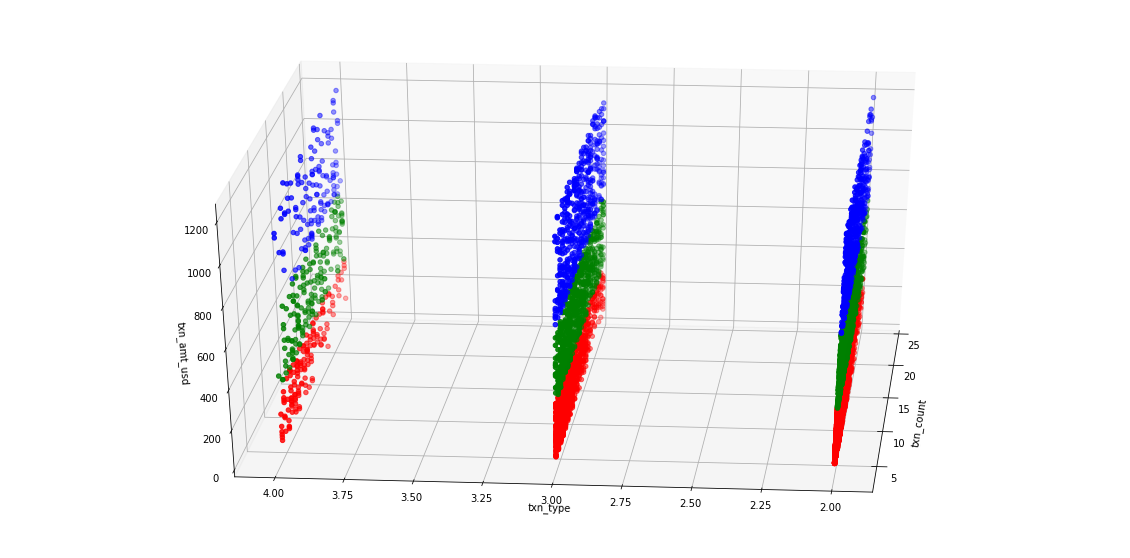

In [ ]:
#cluster of users in 3 dimensions

fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111,projection='3d')

ax.scatter(firstbatch_clean_data['No_of_trans'][firstbatch_clean_data['cluster']==0],firstbatch_clean_data['Total_distinct_trans_type'][firstbatch_clean_data['cluster']==0],firstbatch_clean_data['Total_USD_amount'][firstbatch_clean_data['cluster']==0],c='red')
ax.scatter(firstbatch_clean_data['No_of_trans'][firstbatch_clean_data['cluster']==1],firstbatch_clean_data['Total_distinct_trans_type'][firstbatch_clean_data['cluster']==1],firstbatch_clean_data['Total_USD_amount'][firstbatch_clean_data['cluster']==1],c='blue')
ax.scatter(firstbatch_clean_data['No_of_trans'][firstbatch_clean_data['cluster']==2],firstbatch_clean_data['Total_distinct_trans_type'][firstbatch_clean_data['cluster']==2],firstbatch_clean_data['Total_USD_amount'][firstbatch_clean_data['cluster']==2],c='green')
ax.view_init(30,185)

plt.xlabel('txn_count')
plt.ylabel('txn_type')
ax.set_zlabel('txn_amt_usd')


plt.show()

**Cluster based on txn_amt_avg, txn_count, txn_type_avg, txn_days_avg**

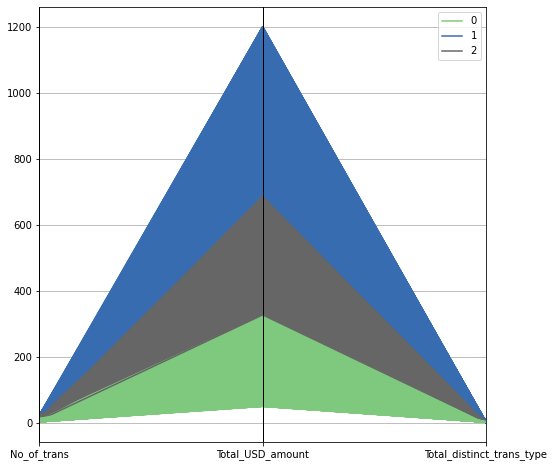

In [ ]:
# Cluster of users in 3 dimensions

plt.figure(figsize=(8,8))
parallel_coordinates(firstbatch_clean_data,'cluster',colormap='Accent')

# ii) **Hierarchical Clustering**

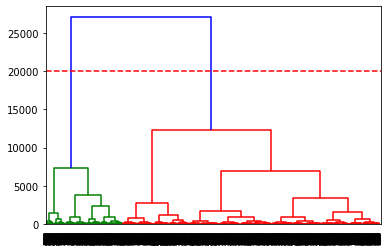

In [ ]:
import scipy.cluster.hierarchy as sch

dendogram=sch.dendrogram(sch.linkage(firstbatch_clean_data,method='ward'))
plt.axhline(y=20000, color='r', linestyle='--')

In [ ]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
s=time.time()
y_predict = cluster.fit_predict(firstbatch_clean_data)
e=time.time()
print("Time Taken by hierarchical clustering = {}".format(e - s))

Time Taken by hierarchical clustering = 1.2025079727172852


In [ ]:
clf = NearestCentroid()
clf.fit(firstbatch_clean_data, y_predict)
print("Centroids:")
print(clf.centroids_)
h_centroids=clf.centroids_

Centroids:
[[ 12.68321678 852.99720979   2.65244755]
 [  8.30640201 200.59478054   2.38356164]
 [ 11.14039409 489.93711823   2.54679803]]


In [ ]:
H_Centroids=pd.DataFrame(h_centroids)
H_Centroids.columns=['Cluster 0','Cluster 1','Cluster 2']
H_Centroids=H_Centroids.sort_values(by=['Cluster 0']).reset_index()
H_Centroids.drop('index',inplace=True,axis=1)
H_Centroids

,Cluster 0,Cluster 1,Cluster 2
0,8.306402,200.594781,2.383562
1,11.140394,489.937118,2.546798
2,12.683217,852.997210,2.652448


In [ ]:
firstbatch_clean_data['cluster']=Kmeans_pred
firstbatch_clean_data['H_cluster']=cluster.labels_

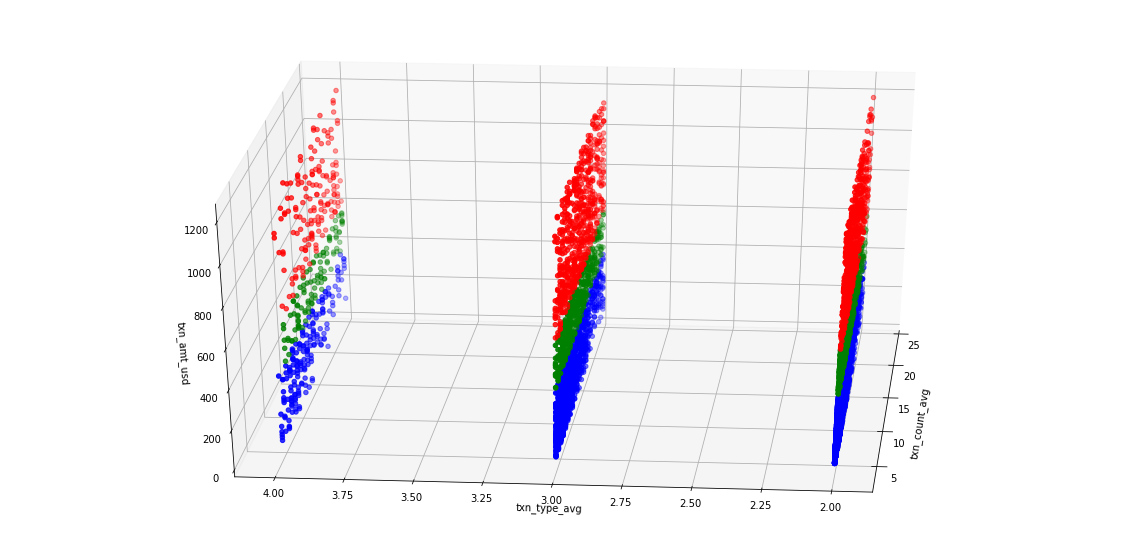

In [ ]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111,projection='3d')

ax.scatter(firstbatch_clean_data['No_of_trans'][firstbatch_clean_data['H_cluster']==0],firstbatch_clean_data['Total_distinct_trans_type'][firstbatch_clean_data['H_cluster']==0],firstbatch_clean_data['Total_USD_amount'][firstbatch_clean_data['H_cluster']==0],c='red')
ax.scatter(firstbatch_clean_data['No_of_trans'][firstbatch_clean_data['H_cluster']==1],firstbatch_clean_data['Total_distinct_trans_type'][firstbatch_clean_data['H_cluster']==1],firstbatch_clean_data['Total_USD_amount'][firstbatch_clean_data['H_cluster']==1],c='blue')
ax.scatter(firstbatch_clean_data['No_of_trans'][firstbatch_clean_data['H_cluster']==2],firstbatch_clean_data['Total_distinct_trans_type'][firstbatch_clean_data['H_cluster']==2],firstbatch_clean_data['Total_USD_amount'][firstbatch_clean_data['H_cluster']==2],c='green')
ax.view_init(30,185)

plt.xlabel('txn_count_avg')
plt.ylabel('txn_type_avg')
ax.set_zlabel('txn_amt_usd')

plt.show()

# **2. Compare the centroid values of the two clustering algorithms across each dimension in each cluster**


In [ ]:
result=pd.concat([kmeans_centroids, H_Centroids], axis=1, join='inner')
result.columns=['txn_cnt_Kmeans_Centroid','txn_amt_Kmeans_Centroid','txn_type_Kmeans_Centroid','txn_cnt_hierarchical_Centroid','txn_amt_hierarchical_Centroid','txn_type_hierarchical_Centroid']
result=result[['txn_cnt_Kmeans_Centroid','txn_cnt_hierarchical_Centroid','txn_amt_Kmeans_Centroid','txn_amt_hierarchical_Centroid','txn_type_Kmeans_Centroid','txn_type_hierarchical_Centroid']]
result

,txn_cnt_Kmeans_Centroid,txn_cnt_hierarchical_Centroid,txn_amt_Kmeans_Centroid,txn_amt_hierarchical_Centroid,txn_type_Kmeans_Centroid,txn_type_hierarchical_Centroid
0,7.978107,8.306402,176.776819,200.594781,2.366388,2.383562
1,11.195344,11.140394,481.703254,489.937118,2.542004,2.546798
2,12.699913,12.683217,903.886719,852.997210,2.666667,2.652448


From the above table, Kmeans Centroid and hierarchical Centroid produce quite similar in clustering the users based on above multidimension metric.

# **3. Which of the two algorithms is a better choice for defining the engagement metric?**

Time Taken by Hierarchical clustering = 1.20 seconds<br>
Time Taken by K-Means = 0.23 seconds

As Hierarchical Clustering is computationally expensive.

So, **K-means algorithm is optimal.**

# **4. How may the centroid values from the optimal algorithm be used to define a business rule for tagging engaged vs. unengaged users?**

RULE 1: txn_amount<200 = **UnEngaged User**<br>
Rule 2: txn_amount>300 = **Engaged User**